## Columns to be removed from training/validation

# Load Tensorflow and check GPU availability

In [11]:
import numpy as np
import tensorflow as tf
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

import sys


    
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

2025-01-17 23:56:13.415427: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-17 23:56:13.415462: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-17 23:56:13.445175: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-17 23:56:13.509353: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


cpu


# Load input datasets

In [3]:
import pyarrow as pa
import pyarrow.parquet as pq
import pandas as pd
from pandas import DataFrame
from pandas.core.dtypes import common as com
from pyarrow import Table


def union_tables(tables: [pa.Table]) -> pa.Table:
    union_table = tables[0]
    for table in tables[1:]:
        right_not_in_union = union_table.join(right_table=table, keys='domain_name', join_type='right anti',
                                              coalesce_keys=True, use_threads=True)
        union_table = pa.concat_tables([union_table, right_not_in_union])
    return union_table

# #############################################################
# EDIT this to specify benign / malicious datasets to use     #
# #############################################################
benign_dataset_filenames = [
    'parkets/benign_2312.parquet', 
]
malicious_dataset_filenames = [
    'parkets/phishing_2406_strict.parquet'
]
# #############################################################
# EDIT this for to set appropriate labels (malware, dga, ...) #
# #############################################################
benign_label = "benign"
malicious_label = "phishing"
# #############################################################

# Unify malicious datasets and benign datasets
schema = (pq.read_table(malicious_dataset_filenames[0])).schema # Use the schema from the first malicious filename
benign_tables = [pq.read_table(filename).cast(schema) for filename in benign_dataset_filenames]
malicious_tables = [pq.read_table(filename).cast(schema) for filename in malicious_dataset_filenames]
malicious = union_tables(malicious_tables)
benign = union_tables(benign_tables)

# Convert pyarrow tables to pandas dataframes
df_benign = benign.to_pandas()
df_malicious = malicious.to_pandas()

# Set appropriate labels
df_benign["label"] = benign_label
df_malicious["label"] = malicious_label
class_map = {benign_label: 0, malicious_label: 1}



# ===================
# AUTO BALANCING !!!
# Subsample benign to match the size of malicious
# df_benign = df_benign.sample(n=len(df_malicious))
# ===================

# Concatentate benign and malicious
df = pd.concat([df_benign, df_malicious])


def cast_timestamp(df: DataFrame):
    """
    Cast timestamp fields to seconds since epoch.
    """
    for col in df.columns:
        if com.is_timedelta64_dtype(df[col]):
            df[col] = df[col].dt.total_seconds()  # This converts timedelta to float (seconds)
        elif com.is_datetime64_any_dtype(df[col]):
            df[col] = df[col].astype(np.int64) // 10**9  # Converts datetime64 to Unix timestamp (seconds)

    return df

df = cast_timestamp(df)

# Handle NaNs
df.fillna(-1, inplace=True)


# SUBSAMPLE1 (OPTIONAL)
subsample = 0.01 # 1.0 means no subsample
if subsample < 1.0:
    df = df.sample(frac=subsample)

# Drop the domain name column
df.drop("domain_name", axis=1, inplace=True)

        
# drop all columns that are not tls 
tls_columns = [col for col in df.columns if 'tls' in col]
df = df[tls_columns + ['label']]


labels = df['label'].apply(lambda x: class_map[x]) # y vector
features = df.drop('label', axis=1).copy() # X matrix

print(f"Total samples: {len(df)}")
print(f"Benign count: {len(df_benign)}")
print(f"Malicious count: {len(df_malicious)}")

# Create new features
features['tls_cert_validity_ratio'] = features['tls_root_cert_validity_len'] / (features['tls_leaf_cert_validity_len'] + 1e-6)
features['tls_cert_validity_diff'] = features['tls_root_cert_validity_len'] - features['tls_leaf_cert_validity_len']
features['tls_policies_total_count'] = (features['tls_with_policies_crt_count'] +
                                        features['tls_x509_anypolicy_crt_count'] +
                                        features['tls_iso_policy_crt_count'] +
                                        features['tls_joint_isoitu_policy_crt_count'])
features['tls_auth_cert_ratio'] = (features['tls_server_auth_crt_count'] + 1) / (features['tls_client_auth_crt_count'] + 1)
features['tls_root_leaf_hash_match'] = (features['tls_root_authority_hash'] == features['tls_leaf_authority_hash']).astype(int)
features['tls_chain_cert_len_combined'] = features['tls_chain_len'] * features['tls_cert_validity_ratio']
features['tls_cipher_id_normalized'] = features['tls_negotiated_cipher_id'] / features['tls_negotiated_cipher_id'].max()

# Optional: Compute entropy-based features (requires scipy)
from scipy.stats import entropy
features['tls_cipher_entropy'] = entropy(features['tls_negotiated_cipher_id'].value_counts(normalize=True))
features['tls_version_entropy'] = entropy(features['tls_negotiated_version_id'].value_counts(normalize=True))

print(f"Total features after augmentation: {features.shape[1]}")




df

Total samples: 6266
Benign count: 462192
Malicious count: 164425
Total features after augmentation: 33


,tls_has_tls,tls_chain_len,tls_is_self_signed,tls_root_authority_hash,tls_leaf_authority_hash,tls_negotiated_version_id,tls_negotiated_cipher_id,tls_root_cert_validity_len,tls_leaf_cert_validity_len,tls_broken_chain,...,tls_x509_anypolicy_crt_count,tls_iso_policy_crt_count,tls_joint_isoitu_policy_crt_count,tls_subject_count,tls_server_auth_crt_count,tls_client_auth_crt_count,tls_CA_certs_in_chain_ratio,tls_unique_SLD_count,tls_common_name_count,label
11186,True,2.0,0.0,484934813.0,484934813.0,3.0,2.0,-1.0,-1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,phishing
105203,True,4.0,0.0,484934813.0,484934813.0,3.0,2.0,-1.0,-1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,phishing
219194,True,3.0,0.0,484934813.0,484934813.0,2.0,5.0,-1.0,-1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,benign
131014,True,3.0,0.0,484934813.0,484934813.0,3.0,1.0,-1.0,-1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,phishing
103432,True,2.0,0.0,484934813.0,484934813.0,2.0,5.0,-1.0,-1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,benign
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166489,True,3.0,0.0,484934813.0,484934813.0,2.0,0.0,-1.0,-1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,benign
289727,True,2.0,0.0,484934813.0,484934813.0,3.0,2.0,-1.0,-1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,benign
152870,False,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,phishing
292063,True,3.0,0.0,484934813.0,484934813.0,3.0,2.0,-1.0,-1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,benign


# Data preprocessing

In [4]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import joblib
 
scaler = StandardScaler()
scaled_data = scaler.fit_transform(features)
features = pd.DataFrame(scaled_data, columns=features.columns)

# Save the scaler
joblib.dump(scaler, "scalers/phishing_deepnn_scaler.joblib")

pd.set_option('display.max_columns', None)
features

,tls_has_tls,tls_chain_len,tls_is_self_signed,tls_root_authority_hash,tls_leaf_authority_hash,tls_negotiated_version_id,tls_negotiated_cipher_id,tls_root_cert_validity_len,tls_leaf_cert_validity_len,tls_broken_chain,tls_expired_chain,tls_total_extension_count,tls_critical_extensions,tls_with_policies_crt_count,tls_percentage_crt_with_policies,tls_x509_anypolicy_crt_count,tls_iso_policy_crt_count,tls_joint_isoitu_policy_crt_count,tls_subject_count,tls_server_auth_crt_count,tls_client_auth_crt_count,tls_CA_certs_in_chain_ratio,tls_unique_SLD_count,tls_common_name_count,tls_cert_validity_ratio,tls_cert_validity_diff,tls_policies_total_count,tls_auth_cert_ratio,tls_root_leaf_hash_match,tls_chain_cert_len_combined,tls_cipher_id_normalized,tls_cipher_entropy,tls_version_entropy
0,0.399657,-0.205460,0.372486,0.239307,0.162825,0.547634,0.060605,-0.196844,-0.07325,0.397249,0.471566,-0.22695,-0.223007,0.019024,0.213662,0.211212,0.314906,0.146000,-0.033486,0.073578,0.074182,0.334144,0.066166,0.013230,-0.194987,-0.194839,0.162270,-0.019243,0.165982,-0.196264,0.060605,0.0,-1.110223e-16
1,0.399657,1.164129,0.372486,0.239307,0.162825,0.547634,0.060605,-0.196844,-0.07325,0.397249,0.471566,-0.22695,-0.223007,0.019024,0.213662,0.211212,0.314906,0.146000,-0.033486,0.073578,0.074182,0.334144,0.066166,0.013230,-0.194987,-0.194839,0.162270,-0.019243,0.165982,-0.023006,0.060605,0.0,-1.110223e-16
2,0.399657,0.479334,0.372486,0.239307,0.162825,-0.188892,1.627668,-0.196844,-0.07325,0.397249,0.471566,-0.22695,-0.223007,0.019024,0.213662,0.211212,0.314906,0.146000,-0.033486,0.073578,0.074182,0.334144,0.066166,0.013230,-0.194987,-0.194839,0.162270,-0.019243,0.165982,-0.109635,1.627668,0.0,-1.110223e-16
3,0.399657,0.479334,0.372486,0.239307,0.162825,0.547634,-0.461749,-0.196844,-0.07325,0.397249,0.471566,-0.22695,-0.223007,0.019024,0.213662,0.211212,0.314906,0.146000,-0.033486,0.073578,0.074182,0.334144,0.066166,0.013230,-0.194987,-0.194839,0.162270,-0.019243,0.165982,-0.109635,-0.461749,0.0,-1.110223e-16
4,0.399657,-0.205460,0.372486,0.239307,0.162825,-0.188892,1.627668,-0.196844,-0.07325,0.397249,0.471566,-0.22695,-0.223007,0.019024,0.213662,0.211212,0.314906,0.146000,-0.033486,0.073578,0.074182,0.334144,0.066166,0.013230,-0.194987,-0.194839,0.162270,-0.019243,0.165982,-0.196264,1.627668,0.0,-1.110223e-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6261,0.399657,0.479334,0.372486,0.239307,0.162825,-0.188892,-0.984104,-0.196844,-0.07325,0.397249,0.471566,-0.22695,-0.223007,0.019024,0.213662,0.211212,0.314906,0.146000,-0.033486,0.073578,0.074182,0.334144,0.066166,0.013230,-0.194987,-0.194839,0.162270,-0.019243,0.165982,-0.109635,-0.984104,0.0,-1.110223e-16
6262,0.399657,-0.205460,0.372486,0.239307,0.162825,0.547634,0.060605,-0.196844,-0.07325,0.397249,0.471566,-0.22695,-0.223007,0.019024,0.213662,0.211212,0.314906,0.146000,-0.033486,0.073578,0.074182,0.334144,0.066166,0.013230,-0.194987,-0.194839,0.162270,-0.019243,0.165982,-0.196264,0.060605,0.0,-1.110223e-16
6263,-2.502143,-2.259845,-2.446354,-1.958643,-1.699344,-2.398469,-1.506458,-0.196844,-0.07325,-2.497123,-2.364164,-0.22695,-0.223007,-1.434720,-2.170326,-2.013083,-2.305547,-1.842776,-0.308124,-1.692864,-1.693214,-2.409353,-1.125202,-1.441115,-0.194987,-0.194839,-1.989654,NaN,0.165982,-0.456150,-1.506458,0.0,-1.110223e-16
6264,0.399657,0.479334,0.372486,0.239307,0.162825,0.547634,0.060605,-0.196844,-0.07325,0.397249,0.471566,-0.22695,-0.223007,0.019024,0.213662,0.211212,0.314906,0.146000,-0.033486,0.073578,0.074182,0.334144,0.066166,0.013230,-0.194987,-0.194839,0.162270,-0.019243,0.165982,-0.109635,0.060605,0.0,-1.110223e-16


# Train-test split

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(
  features,
  labels,
  test_size=0.2,
  random_state=42,
  shuffle=True, 
  stratify=labels
)

# Define the NN model

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AttentionNet(nn.Module):
    def __init__(self, feature_size):
        super(AttentionNet, self).__init__()
        
        # Input layer
        self.input_layer = nn.Linear(feature_size, 512)
        
        # Hidden layers
        self.hidden1 = nn.Linear(512, 256)
        self.hidden2 = nn.Linear(256, 128)
        
        # Attention mechanism
        self.attention_layer = nn.Linear(128, 1)
        
        # Output layer
        self.output_layer = nn.Linear(128, 1)
        
        # Batch Normalization
        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)
        self.bn3 = nn.BatchNorm1d(128)
        
        # Dropout
        self.dropout = nn.Dropout(0.3)
        
        # Skip connections
        self.skip_connection = nn.Linear(feature_size, 128)
    
    def forward(self, x):
        # Input layer with normalization
        x = F.relu(self.bn1(self.input_layer(x)))
        
        # Hidden layers with dropout
        x = F.relu(self.bn2(self.hidden1(x)))
        x = self.dropout(x)
        x = F.relu(self.bn3(self.hidden2(x)))
        x = self.dropout(x)
        
        # Skip connection
        skip = F.relu(self.skip_connection(x))
        x = x + skip  # Residual addition
        
        # Attention mechanism
        attention_weights = torch.sigmoid(self.attention_layer(x))
        x = x * attention_weights  # Apply attention weights
        
        # Output layer (logits)
        x = self.output_layer(x)
        return x

# Example configuration for optimizer
def configure_optimizers(model, lr=1e-3):
    return torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)


In [7]:
def compute_metrics(data_loader, model):
    model.eval()
    true_labels = []
    predictions = []

    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            probs = torch.sigmoid(output)  # Apply sigmoid here
            true_labels.extend(target.cpu().numpy())
            predictions.extend(probs.round().cpu().numpy())

    accuracy = accuracy_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions)
    return accuracy, f1, predictions, true_labels

In [8]:
import torch.nn.functional as F
import math

def prepare_dataset(X_train, Y_train, X_test, Y_test):
    x_train = torch.tensor(X_train.values, dtype=torch.float32)
    y_train = torch.tensor(Y_train.values, dtype=torch.float32)  # Use float32
    x_test = torch.tensor(X_test.values, dtype=torch.float32)
    y_test = torch.tensor(Y_test.values, dtype=torch.float32)  # Use float32
    return x_train, y_train, x_test, y_test


# print feature size

In [9]:
x_train, y_train, x_test, y_test = prepare_dataset(X_train, Y_train, X_test, Y_test)




# Train the model

In [14]:
from sklearn.utils import class_weight
import torch.optim as optim

# Hyperparameters
LEARNING_RATE = 0.0043
BATCH_SIZE = 32
EPOCHS = 200


class_weights = class_weight.compute_class_weight('balanced', classes=[0, 1], y=y_train.numpy())
weights = torch.tensor(class_weights, dtype=torch.float).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=weights[1])


model = AttentionNet(x_train.shape[1]).to(device)


optimizer = configure_optimizers(model, lr=LEARNING_RATE)



scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)  # Adjust step_size and gamma as needed


train_data = TensorDataset(x_train.to(device), y_train.float().unsqueeze(1).to(device))  # Ensure y_train is float and of shape (batch_size, 1)
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

test_data = TensorDataset(x_test.to(device), y_test.float().unsqueeze(1).to(device))  # Ensure y_test is float and of shape (batch_size, 1)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

epoch_losses = []
epoch_accuracies = []
epoch_f1s = []


# # Training loop
# Training loop
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        
        output = model(data)  # Logits
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        
    scheduler.step()

    avg_loss = running_loss / len(train_loader)
    epoch_losses.append(avg_loss)

    # Evaluate model
    train_accuracy, train_f1, _, _ = compute_metrics(train_loader, model)
    epoch_accuracies.append(train_accuracy)
    epoch_f1s.append(train_f1)

    print(f"Epoch {epoch+1}/{EPOCHS} - Loss: {avg_loss:.4f}, Accuracy: {train_accuracy:.4f}, F1 Score: {train_f1:.4f}")





RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x33 and 32x512)

# Save the model

In [110]:
# save trained model 
torch.save(model.state_dict(), 'trained_phishing_model.pth')

# Testing trained model

CNN model created
Test Accuracy: 0.9468, Test F1 Score: 0.8979


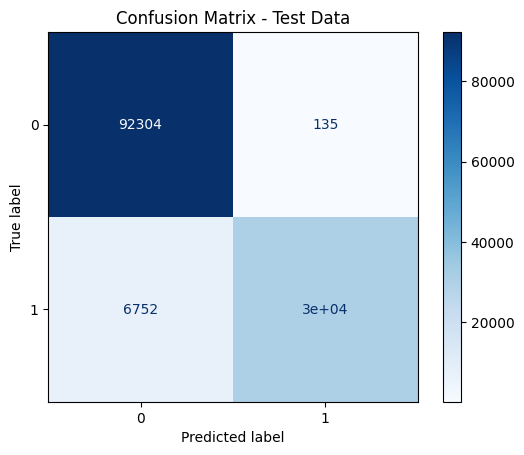

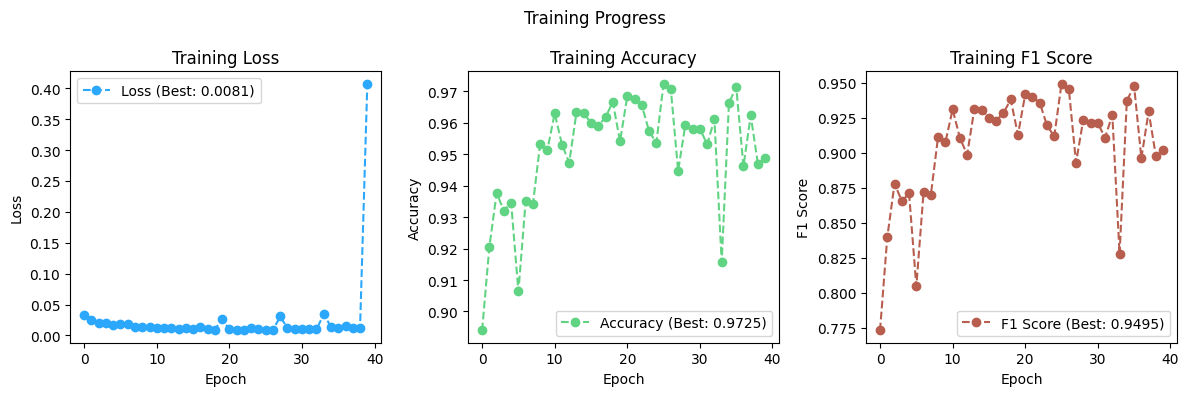

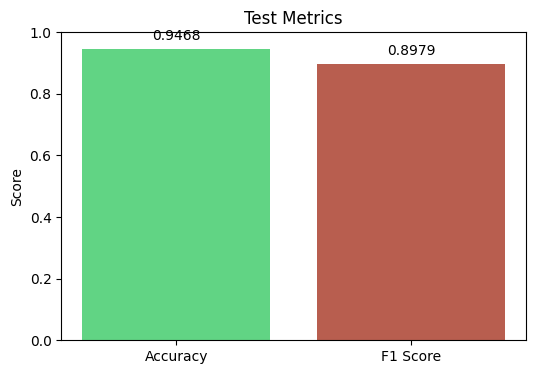

In [112]:
import matplotlib.pyplot as plt

test_data = TensorDataset(x_test.to(device), y_test.float().unsqueeze(1).to(device))  # Ensure y_test is float and of shape (batch_size, 1)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)


# load model
model = Net(feature_size=173).to(device)
model.load_state_dict(torch.load('./models/malware_residual.pth'))

# Evaluate on the test set
test_accuracy, test_f1, predictions, true_labels = compute_metrics(test_loader, model)
print(f"Test Accuracy: {test_accuracy:.4f}, Test F1 Score: {test_f1:.4f}")

# Plotting the confusion matrix
cm = confusion_matrix(true_labels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Test Data')
plt.show()

# Plotting the training progress
plt.figure(figsize=(12, 4))

# Plot for Loss
plt.subplot(1, 3, 1)
plt.plot(epoch_losses, linestyle='--', marker='o', color='#2ba7fc', label=f'Loss (Best: {min(epoch_losses):.4f})')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

# Plot for Accuracy
plt.subplot(1, 3, 2)
plt.plot(epoch_accuracies, linestyle='--', marker='o', color='#61d484', label=f'Accuracy (Best: {max(epoch_accuracies):.4f})')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()

# Plot for F1 Score
plt.subplot(1, 3, 3)
plt.plot(epoch_f1s, linestyle='--', marker='o', color='#b85e4f', label=f'F1 Score (Best: {max(epoch_f1s):.4f})')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('Training F1 Score')
plt.legend()

plt.suptitle('Training Progress')
plt.tight_layout()
plt.show()

# Plotting the testing results
plt.figure(figsize=(6, 4))

metrics = ['Accuracy', 'F1 Score']
values = [test_accuracy, test_f1]
colors = ['#61d484', '#b85e4f']

plt.bar(metrics, values, color=colors)
plt.ylim(0, 1)
for i, v in enumerate(values):
    plt.text(i, v + 0.02, f"{v:.4f}", ha='center', va='bottom')
plt.ylabel('Score')
plt.title('Test Metrics')
plt.show()

# bylo 2k na 2k


# Validate the model on a separate Validation dataset

CNN model created
torch.Size([2480, 1, 14, 14])
torch.Size([2480])
Accuracy: 0.5326612903225807
Weighted Accuracy: 0.5326612903225807
Precision: 0.17243920412675018
Recall: 0.8666666666666667
F1 Score: 0.2876459741856177
False Positive Rate: 0.5081447963800905


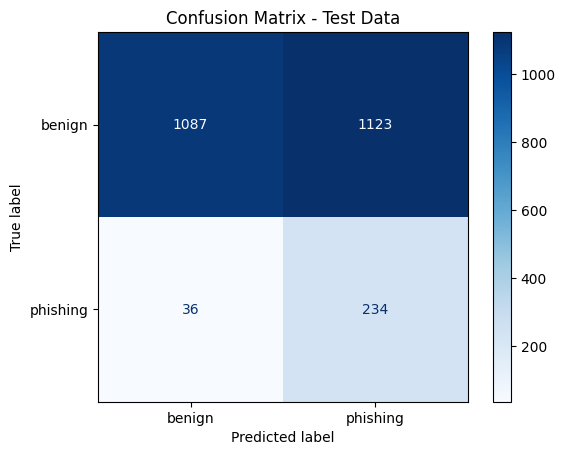

Misclassified domains: ['www.manners-biz.com', 'www.microtransindia.com', 'www.tekutaguma.sk', 'www.biozide.at', 'www.deezer.com', '3793svxn.computer-mod-s.tech', 'plinkos-organization.gitbook.io', 's.viiwzrlr.com', 'www.scientificamerican.com', 'www.donemo.cz', 'cdn7.dissolve.com', 'assets.tractive.com', 'www.pokernews.com', 'www.anatomionline.dk', '5c7021242c10k1d2.tap4hub.com', 'www.hanackakrcma.cz', 'krakenperu.com', 'www.holotaco.com', 'client-deploy.swpcld.com', 'consent.sportbible.com', 'flucast31-h-cloud.flumotion.com', 'dmm.nihonjav.com', 'webhosting1.kabel1.cz', 't3a.coupangcdn.com', 'o4505883345354752.ingest.sentry.io', 's3-media1.fl.yelpcdn.com', 'identity.getvideostream.com', 'cooking-prod.tuanguwen.com', 'www.authenticbeautyconcept.cz', 'productions.com', 'www.grooters.cz', '0162xygl.computer-mod-s.tech', 'corporate.target.com', 'frontend2.locally.com', 'www.databazeknih.cz', 'pvz2-live.ecs.popcap.com', 'cdn.sunporno.com', 'www.pragmatik.cz', 'iapi.bbapsell.com', 'ws-keyb

In [114]:
import pyarrow.parquet as pq
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import joblib
from tensorflow.keras.models import load_model
from pandas.core.dtypes import common as com
import numpy as np

def cast_timestamp(df: pd.DataFrame):
    """
    Cast timestamp fields to seconds since epoch.
    """
    for col in df.columns:
        if com.is_timedelta64_dtype(df[col]):
            df[col] = df[col].dt.total_seconds()  # This converts timedelta to float (seconds)
        elif com.is_datetime64_any_dtype(df[col]):
            df[col] = df[col].astype(np.int64) // 10**9  # Converts datetime64 to Unix timestamp (seconds)
    return df

# Load the validation dataset
validation_dataset_filename = '../testdata/validation_phishing.parquet'
df_validation = pq.read_table(validation_dataset_filename).to_pandas()

# Cast timestamps and handle NaNs
df_validation = cast_timestamp(df_validation)
df_validation.fillna(-1, inplace=True)

# Remove disqualified columns
for column in disqualified_columns:
    if column in df_validation.columns:
        df_validation.drop(column, axis=1, inplace=True)

# Map the labels
df_validation['label'] = df_validation['label'].map({'benign': 0, 'phishing': 1})

# Extract features and labels
X_val = df_validation.drop(['label', 'domain_name'], axis=1)
y_val = df_validation['label']

# Load the scaler
scaler = joblib.load("boundaries/phishing_deepnn_scaler.joblib")

# Scale the features
y_val = y_val.tolist()
X_val_scaled = scaler.transform(X_val)
# convert to tensor
X_val_scaled = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
# convert pandas series y_val to llist

# print shape of X_val_scaled and y_val_tensor




# Load the trained model
model = Net(side_size=14)
model.load_state_dict(torch.load('trained_phishing_model_v2.pth'))
model.eval()
model.to('cuda:0' if torch.cuda.is_available() else 'cpu')

#### PADDING ###
# Helper function to find the next perfect square
def next_perfect_square(n):
    next_square = math.ceil(n**0.5)**2
    return next_square

# Calculate the side size for the square shape dynamically
feature_size = X_val_scaled.shape[1]
desired_size = next_perfect_square(feature_size)
side_size = int(desired_size ** 0.5)

# Calculate padding required to achieve the desired size
padding = desired_size - feature_size

# Applying dynamic padding
if padding > 0:
    X_val_padded = F.pad(X_val_scaled, (0, padding), 'constant', 0)
else:
    X_val_padded = X_val_scaled

# Reshape the data to the new dynamically calculated square shape
X_val_final = X_val_padded.view(-1, 1, side_size, side_size)

print(X_val_final.shape)
print(y_val_tensor.shape)
# Prepare DataLoader



val_data = TensorDataset(X_val_final, y_val_tensor)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)

# Function to compute metrics and predictions
def compute_metrics_and_predictions(data_loader, model):
    model.eval()
    true_labels = []
    predictions = []
    probabilities = []

    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            true_labels.extend(target.cpu().numpy())
            predictions.extend(torch.sigmoid(output).round().cpu().numpy())


    return true_labels, predictions





# Get predictions and probabilities
test_true_labels, test_predictions= compute_metrics_and_predictions(val_loader, model)

# Calculate metrics
accuracy = accuracy_score(test_true_labels, test_predictions)
weighted_accuracy = (accuracy_score(np.array(test_true_labels) == 0, np.array(test_predictions) == 0) + accuracy_score(np.array(test_true_labels) == 1, np.array(test_predictions) == 1)) / 2
precision = precision_score(test_true_labels, test_predictions)
recall = recall_score(test_true_labels, test_predictions)
f1 = f1_score(test_true_labels, test_predictions)
tn, fp, fn, tp = confusion_matrix(test_true_labels, test_predictions).ravel()
false_positive_rate = fp / (fp + tn)

# Display metrics
print(f'Accuracy: {accuracy}')
print(f'Weighted Accuracy: {weighted_accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'False Positive Rate: {false_positive_rate}')

# Display confusion matrix
cm = confusion_matrix(test_true_labels, test_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['benign', 'phishing'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Test Data')
plt.show()

# Identify misclassified domain names
misclassified = df_validation.iloc[[i for i, (y_true, y_pred) in enumerate(zip(test_true_labels, test_predictions)) if y_true != y_pred]]
misclassified_domains = misclassified['domain_name'].tolist()
print(f'Misclassified domains: {misclassified_domains}')


# Make test predictions

In [21]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
import joblib
import pyarrow as pa
import pyarrow.parquet as pq
import pandas as pd
from pyarrow import Table

# Load the model and scaler
model = load_model('dga_binary_model.keras')
scaler = joblib.load("dga_binary_scaler.joblib")

# #############################################################
# EDIT this to specify benign / malicious datasets to use     #
# #############################################################
benign_dataset_filenames = [
    '../feature-extraction/floor/benign_2312_anonymized.parquet',
    '../feature-extraction/floor/umbrella_benign_FINISHED.parquet',
]
malicious_dataset_filenames = [
    '../feature-extraction/floor/lex-dga-830k-pick.parquet'
]
# #############################################################
# EDIT this for to set appropriate labels (malware, dga, ...) #
# #############################################################
benign_label = "benign"
malicious_label = "dga"
# #############################################################

def union_tables(tables: [pa.Table]) -> pa.Table:
    union_table = tables[0]
    for table in tables[1:]:
        right_not_in_union = union_table.join(right_table=table, keys='domain_name', join_type='right anti',
                                              coalesce_keys=True, use_threads=True)
        union_table = pa.concat_tables([union_table, right_not_in_union])
    return union_table

# Unify malicious datasets and benign datasets
schema = (pq.read_table(malicious_dataset_filenames[0])).schema # Use the schema from the first malicious filename
benign_tables = [pq.read_table(filename).cast(schema) for filename in benign_dataset_filenames]
malicious_tables = [pq.read_table(filename).cast(schema) for filename in malicious_dataset_filenames]
malicious = union_tables(malicious_tables)
benign = union_tables(benign_tables)

# Convert pyarrow tables to pandas dataframes
df_benign = benign.to_pandas()
df_malicious = malicious.to_pandas()

# Set appropriate labels
df_benign["label"] = benign_label
df_malicious["label"] = malicious_label
class_map = {benign_label: 0, malicious_label: 1}

# Concatentate benign and malicious
test_df = pd.concat([df_benign, df_malicious])

# Handle NaNs
test_df.fillna(-1, inplace=True)


# Take only N random samples
N = 500
test_df = test_df.sample(n=N, random_state=42)

total_predictions = 0
correct_predictions = 0

for index, row in test_df.iterrows():
    domain_name = row['domain_name']
    original_label = row['label']
    
    # Drop "domain_name" and "label" columns
    feature_vector = pd.DataFrame([row])
    feature_vector.drop(columns=['domain_name', 'label'], inplace=True)

     # Scale the feature vector using the loaded scaler
    scaled_feature_vector = scaler.transform(feature_vector)
    
    # Perform prediction
    prediction = model.predict(scaled_feature_vector, verbose=0)
    
    # Extract the predicted class
    predicted_label = "benign" if prediction < 0.5 else "dga"
    
    # Check if the prediction was correct
    if original_label == predicted_label:
        correct_predictions += 1
    
    total_predictions += 1
    
    # Print the result
    result="WRONG"
    if predicted_label == original_label:
        result="OK"
        
    pred_disp = "!!! DGA !!!"
    if predicted_label == "benign":
        pred_disp = "BENIGN"
        
    
    print(f"{result} | {domain_name} ({original_label}), Predicted: {pred_disp}, Prob: {prediction}")

# Calculate accuracy
accuracy = correct_predictions / total_predictions
print(f"Accuracy: {accuracy}")




OSError: No file or directory found at dga_binary_model.keras

OK | tube-2.xvideo.party (benign), Predicted: BENIGN, Prob: [[3.3207368e-17]]
OK | sportmas.bike (benign), Predicted: BENIGN, Prob: [[1.4945806e-05]]
OK | journals.epu.edu.iq (benign), Predicted: BENIGN, Prob: [[4.2451488e-17]]
OK | gurmans.dp.ua (benign), Predicted: BENIGN, Prob: [[3.2404896e-05]]
OK | avedesign.studio (benign), Predicted: BENIGN, Prob: [[3.3500016e-06]]
OK | cyberlab.sutd.edu.sg (benign), Predicted: BENIGN, Prob: [[3.9096804e-17]]
OK | gbo9dbcl547j19nah661alcwtl.com (dga), Predicted: !!! DGA !!!, Prob: [[0.9996364]]
OK | xruzkonkxwntdmpikq.org (dga), Predicted: !!! DGA !!!, Prob: [[0.9999989]]
OK | east.smtp.mx.exch091.serverdata.net (benign), Predicted: BENIGN, Prob: [[0.]]
OK | triagon.mt (benign), Predicted: BENIGN, Prob: [[0.01530445]]
OK | myvwnbtqeswsox.com (dga), Predicted: !!! DGA !!!, Prob: [[0.99982136]]
OK | hypo.com.ro (benign), Predicted: BENIGN, Prob: [[0.17475085]]
OK | qbogvahnlk.biz (dga), Predicted: !!! DGA !!!, Prob: [[0.99622726]]
OK | sqgnkxbvvhb

OK | iagurf.com (dga), Predicted: !!! DGA !!!, Prob: [[0.9104787]]
OK | chavez.salkeiz.k12.or.us (benign), Predicted: BENIGN, Prob: [[9.879189e-33]]
OK | p-lb.cdtx.co (benign), Predicted: BENIGN, Prob: [[6.2895306e-06]]
OK | p178d042a174871f97bf01ad5b8c2261a1.so (dga), Predicted: !!! DGA !!!, Prob: [[0.99965143]]
OK | i0.tagstat.com (benign), Predicted: BENIGN, Prob: [[7.87963e-07]]
OK | ybf3ei17fm4lo1jr967e1046mr9.net (dga), Predicted: !!! DGA !!!, Prob: [[0.999962]]
OK | ioyldrwmhsmtlj.com (dga), Predicted: !!! DGA !!!, Prob: [[0.9999975]]
OK | vekeualav.name (dga), Predicted: !!! DGA !!!, Prob: [[0.9956891]]
OK | ringwoodsc.vic.edu.au (benign), Predicted: BENIGN, Prob: [[4.456764e-15]]
OK | apps.profitihub.com (benign), Predicted: BENIGN, Prob: [[6.527985e-08]]
OK | sxyxeho.ru (dga), Predicted: !!! DGA !!!, Prob: [[0.93510205]]
OK | xcrixa.com (dga), Predicted: !!! DGA !!!, Prob: [[0.9786981]]
OK | fcf71aea67fd6ff05fcf8412236bcffc.info (dga), Predicted: !!! DGA !!!, Prob: [[0.999417